# Trained Xception network on classification on cervix images

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [16]:
import os
from datetime import datetime
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Project
import sys
sys.path.append(os.path.join(os.path.abspath(os.path.dirname('.')), '..', 'common'))

In [4]:
import matplotlib.pylab as plt
%matplotlib inline

def plt_st(n, m):
    plt.figure(figsize=(n, m))

In [5]:
os.environ['KERAS_BACKEND']='tensorflow'
# os.environ['CUDA_VISIBLE_DEVICES']='0'

In [6]:
from xception_keras202 import get_xception, get_xception_3_dense

Using TensorFlow backend.


In [7]:
print("\n {} - Get Xception model ...".format(datetime.now()))
xception = get_xception(trained=False, finetuning=False)
# xception = get_xception_3_dense()



 2017-04-17 01:17:22.190303 - Get Xception model ...


In [8]:
xception.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864                                          
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128                                          
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0                                            
___________________________________________________________________________________________

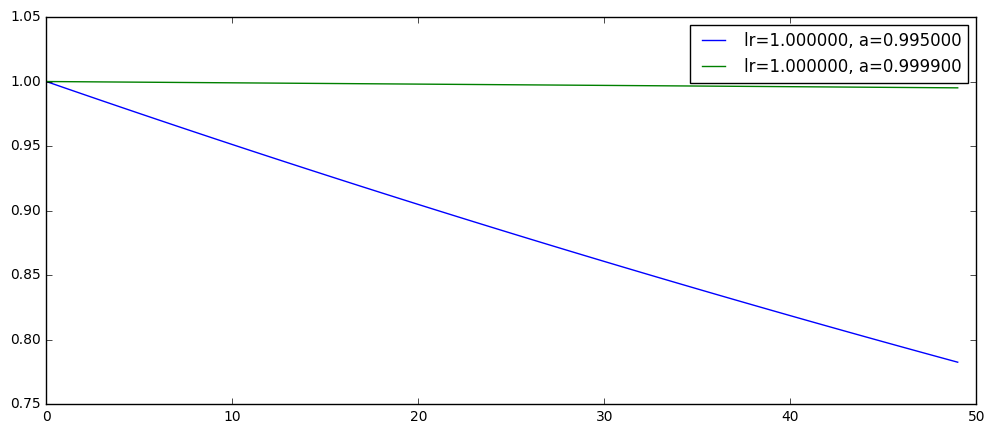

In [10]:
from training_utils import exp_decay

lr_base = 1.0
lr_1 = 1.0 * lr_base; a_1 = 0.995
lr_2 = 1.0 * lr_base; a_2 = 0.9999

epochs = np.arange(0, 50)
lrs_1 = exp_decay(epochs, lr=lr_1, a=a_1)
lrs_2 = exp_decay(epochs, lr=lr_2, a=a_2)
plt_st(12, 5)
plt.plot(epochs, lrs_1, label="lr=%f, a=%f" % (lr_1, a_1))
plt.plot(epochs, lrs_2, label="lr=%f, a=%f" % (lr_2, a_2))
plt.legend()

In [11]:
seed = 2017
np.random.seed(seed)
save_prefix='xception_norm2_cervix_opt=adadelta_seed=%i' % seed

In [12]:
from training_utils import get_trainval_id_type_lists3

print("\n {} - Get train/val lists ...".format(datetime.now()))

train_id_type_list, val_id_type_list = get_trainval_id_type_lists3(val_split=0.15, seed=2017)
print(len(train_id_type_list), len(val_id_type_list))


 2017-04-17 01:18:37.809231 - Get train/val lists ...
1860 330


In [13]:
from glob import glob
from training_utils import find_best_weights_file

weights_files = glob("weights/%s*.h5" % save_prefix)
best_weights_filename, best_val_loss = find_best_weights_file(weights_files)
print("Best val loss weights: ", best_weights_filename)

if len(best_weights_filename) > 0:
    # load weights to the model
    print("Load found weights: ", best_weights_filename)
    xception.load_weights(best_weights_filename)

Best val loss weights:  


In [14]:
from xy_providers import DataCache
cache = DataCache(0)

In [ ]:
if True:
    from training_utils import classification_train as train
      
    nb_epochs = 50
    batch_size = 3
    
    lrate_decay_f = lambda epoch: exp_decay(epoch, lr=lr_1, a=a_1) 

    print("\n {} - Start training ...".format(datetime.now()))
    h = train(xception, 
              train_id_type_list, 
              val_id_type_list, 
              option='cervix',
              nb_epochs=nb_epochs,
              samples_per_epoch=2048,
              nb_val_samples=512,
              lrate_decay_f=lrate_decay_f,
              batch_size=batch_size, 
              xy_provider_cache=cache,
              seed=seed,
              save_prefix=save_prefix)


 2017-04-17 09:56:39.132226 - Start training ...

-- Training parameters: 3, 50, 2046, 510

-- Fit model
- New Keras API found -
Epoch 1/50
 14/682 [..............................] - ETA: 1173s - loss: 0.9699 - acc: 0.5476

In [14]:
# weights_filename = os.path.join("weights", save_prefix + "_{epoch:02d}-{val_loss:.4f}.h5")
# weights_filename = weights_filename.format(epoch=50, val_loss=0.9954)
# xception.save_weights(weights_filename)


In [16]:
from training_utils import classification_validate as validate
from test_utils import classification_predict as predict

batch_size = 8

In [17]:
print("\n {} - Start validation ...".format(datetime.now()))
validate(xception, cervix_val_id_type_list, save_prefix=save_prefix, batch_size=batch_size, xy_provider_cache=cache)


 2017-04-10 18:39:56.300780 - Start validation ...
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/xception_trained_3_dense_norm_cervix_adadelta_seed=2017_stats.npz
-- 8 batch loss :  1.1815  | info: [('1199', 'Type_1_cervix') ('678', 'Type_2_cervix')
 ('1364', 'Type_3_cervix') ('1033', 'Type_1_cervix')
 ('1368', 'Type_2_cervix') ('899', 'Type_3_cervix')
 ('441', 'Type_1_cervix') ('403', 'Type_2_cervix')]
-- 16 batch loss :  0.798848  | info: [('289', 'Type_3_cervix') ('55', 'Type_1_cervix') ('538', 'Type_2_cervix')
 ('228', 'Type_3_cervix') ('700', 'Type_1_cervix') ('603', 'Type_2_cervix')
 ('361', 'Type_3_cervix') ('583', 'Type_1_cervix')]
-- 24 batch loss :  0.83741  | info: [('45', 'Type_2_cervix') ('983', 'Type_3_cervix') ('1344', 'Type_1_cervix')
 ('1444', 'Type_2_cervix') ('318', 'Type_3_cervix')
 ('708', 'Type_1_cervix') ('1315', 'Type_2_cervix')
 ('1183', 'Type_3_cervix')]
-- 32 batch loss :  0.469749  | info: [('1389', 'Type_1_cervix') (

In [25]:
print("\n {} - Start predictions and write submission ...".format(datetime.now()))
from test_utils import get_test_id_type_list
test_id_type_list = get_test_id_type_list()
cervix_test_id_type_list = [(id_type[0], id_type[1] + '_cervix') for id_type in test_id_type_list]
predict(xception, cervix_test_id_type_list, save_prefix=save_prefix, info=save_prefix, batch_size=batch_size)


 2017-04-10 18:42:19.416185 - Start predictions and write submission ...
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/xception_trained_3_dense_norm_cervix_adadelta_seed=2017_stats.npz
-- 0 / 512
-- 4 / 512
-- 8 / 512
-- 12 / 512
-- 16 / 512
-- 20 / 512
-- 24 / 512
-- 28 / 512
-- 32 / 512
-- 36 / 512
-- 40 / 512
-- 44 / 512
-- 48 / 512
-- 52 / 512
-- 56 / 512
-- 60 / 512
-- 64 / 512
-- 68 / 512
-- 72 / 512
-- 76 / 512
-- 80 / 512
-- 84 / 512
-- 88 / 512
-- 92 / 512
-- 96 / 512
-- 100 / 512
-- 104 / 512
-- 108 / 512
-- 112 / 512
-- 116 / 512
-- 120 / 512
-- 124 / 512
-- 128 / 512
-- 132 / 512
-- 136 / 512
-- 140 / 512
-- 144 / 512
-- 148 / 512
-- 152 / 512
-- 156 / 512
-- 160 / 512
-- 164 / 512
-- 168 / 512
-- 172 / 512
-- 176 / 512
-- 180 / 512
-- 184 / 512
-- 188 / 512
-- 192 / 512
-- 196 / 512
-- 200 / 512
-- 204 / 512
-- 208 / 512
-- 212 / 512
-- 216 / 512
-- 220 / 512
-- 224 / 512
-- 228 / 512
-- 232 / 512
-- 236 / 512
-- 240 / 512
-- 244 / 

## Analyse predictions

In [15]:
batch_size = 4
from data_utils import GENERATED_DATA
from xy_providers import cached_image_label_provider
from preprocessing.image.generators import ImageDataGenerator

normalize_data = True
image_size = (299, 299)
channels_first = False

xy_provider = cached_image_label_provider
val_gen = ImageDataGenerator(featurewise_center=normalize_data,
                             featurewise_std_normalization=normalize_data)

if normalize_data:
    if False:
        assert len(save_prefix) > 0, "WTF"
        # Load mean, std, principal_components if file exists
        filename = os.path.join(GENERATED_DATA, save_prefix + "_stats.npz")
        assert os.path.exists(filename), "WTF"
        print("Load existing file: %s" % filename)
        npzfile = np.load(filename)
        val_gen.mean = npzfile['mean']
        val_gen.std = npzfile['std']
    else:
        val_gen.mean = 0.5
        val_gen.std = 0.5
        
        
        
flow = val_gen.flow(xy_provider(cervix_val_id_type_list,
                                image_size=image_size,
                                channels_first=channels_first,
                                cache=cache,
                                test_mode=True),
                    # Ensure that all batches have the same size
                    len(cervix_val_id_type_list),
                    batch_size=batch_size)
total_counter = 0

-- 4
('1199', 'Type_1_cervix') [ 0.40595731  0.28316754  0.31087515] [1 0 0]
('678', 'Type_2_cervix') [ 0.32025862  0.32477957  0.35496184] [0 1 0]
('1364', 'Type_3_cervix') [ 0.39227208  0.25596878  0.35175914] [0 0 1]
('1033', 'Type_1_cervix') [ 0.32352778  0.40436217  0.27211007] [1 0 0]


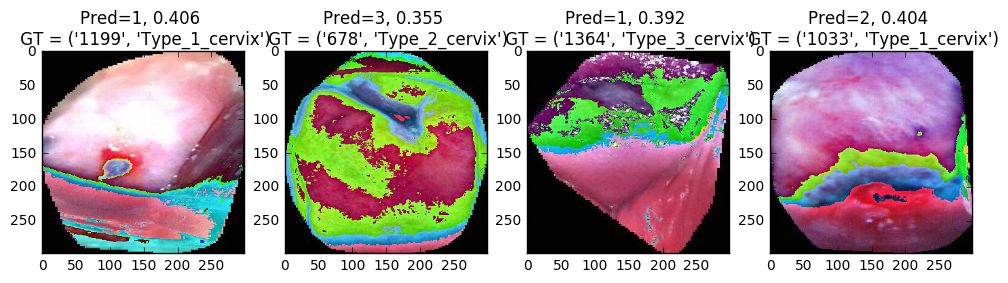

In [16]:
for x, y_true, info in flow:
    s = y_true.shape[0]
    y_pred = xception.predict(x)
    print("--", total_counter*batch_size + s)    
    total_counter += 1
    plt_st(12, 4)
    for i in range(s):
        print(info[i], y_pred[i], y_true[i])
        plt.subplot(1, s, i+1)
        plt.title("Pred={}, {:.3f} \n GT = {}".format(np.argmax(y_pred[i])+1, np.max(y_pred[i]), info[i]))
        plt.imshow(x[i, :, :, :])
    break

### Logs


xception_trained_3_dense_norm_cervix_adadelta_seed=2017

```
2017-04-10 08:19:13.163710 - Start training ...

-- Training parameters: 8, 50, 2048, 1024

-- Fit stats of train dataset
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/xception_trained_3_dense_norm_cervix_adadelta_seed=2017_stats.npz
No need to recompute statistics

-- Fit model
- New Keras API found -
Epoch 1/50
256/256 [] - 556s - loss: 1.1825 - acc: 0.3726 - val_loss: 1.0385 - val_acc: 0.4961
Epoch 2/50
256/256 [] - 553s - loss: 1.0914 - acc: 0.4033 - val_loss: 0.9926 - val_acc: 0.5303
Epoch 3/50
256/256 [] - 553s - loss: 1.0382 - acc: 0.4731 - val_loss: 0.9482 - val_acc: 0.5234
Epoch 4/50
256/256 [] - 553s - loss: 0.9950 - acc: 0.4995 - val_loss: 0.9174 - val_acc: 0.5166
Epoch 5/50
256/256 [] - 552s - loss: 0.9920 - acc: 0.4951 - val_loss: 0.9064 - val_acc: 0.5439
Epoch 6/50
256/256 [] - 552s - loss: 0.9546 - acc: 0.5234 - val_loss: 0.8897 - val_acc: 0.5684
Epoch 7/50
256/256 [] - 552s - loss: 0.9595 - acc: 0.5293 - val_loss: 0.8812 - val_acc: 0.5566
Epoch 8/50
256/256 [] - 552s - loss: 0.9258 - acc: 0.5493 - val_loss: 0.9145 - val_acc: 0.5596
Epoch 9/50
256/256 [] - 552s - loss: 0.9310 - acc: 0.5591 - val_loss: 0.8834 - val_acc: 0.5596
Epoch 10/50
256/256 [] - 552s - loss: 0.9156 - acc: 0.5698 - val_loss: 0.8955 - val_acc: 0.5449
Epoch 11/50
256/256 [] - 552s - loss: 0.8982 - acc: 0.5835 - val_loss: 0.8951 - val_acc: 0.5791
Epoch 12/50
256/256 [] - 552s - loss: 0.9094 - acc: 0.5703 - val_loss: 0.8842 - val_acc: 0.5674
Epoch 13/50
256/256 [] - 552s - loss: 0.8871 - acc: 0.5840 - val_loss: 0.8860 - val_acc: 0.5654
Epoch 14/50
256/256 [] - 552s - loss: 0.9042 - acc: 0.5757 - val_loss: 0.9130 - val_acc: 0.5625
Epoch 15/50
256/256 [] - 552s - loss: 0.9078 - acc: 0.5708 - val_loss: 0.8937 - val_acc: 0.5713
Epoch 16/50
256/256 [] - 552s - loss: 0.8833 - acc: 0.5908 - val_loss: 0.8916 - val_acc: 0.5752
Epoch 17/50
256/256 [] - 552s - loss: 0.8741 - acc: 0.5977 - val_loss: 0.8919 - val_acc: 0.5879
Epoch 18/50
256/256 [] - 552s - loss: 0.8478 - acc: 0.6050 - val_loss: 0.9156 - val_acc: 0.5908
Epoch 19/50
256/256 [] - 552s - loss: 0.8587 - acc: 0.6030 - val_loss: 0.8996 - val_acc: 0.5752
Epoch 20/50
256/256 [] - 552s - loss: 0.8469 - acc: 0.6035 - val_loss: 0.9111 - val_acc: 0.5840
Epoch 21/50
256/256 [] - 551s - loss: 0.8540 - acc: 0.5879 - val_loss: 0.9184 - val_acc: 0.5830
Epoch 22/50
256/256 [] - 551s - loss: 0.8619 - acc: 0.5977 - val_loss: 0.9027 - val_acc: 0.5801
Epoch 23/50
256/256 [] - 551s - loss: 0.8428 - acc: 0.6079 - val_loss: 0.8925 - val_acc: 0.5830
Epoch 24/50
256/256 [] - 551s - loss: 0.8334 - acc: 0.6260 - val_loss: 0.9472 - val_acc: 0.5742
Epoch 25/50
256/256 [] - 551s - loss: 0.8232 - acc: 0.6211 - val_loss: 0.8903 - val_acc: 0.5967
Epoch 26/50
256/256 [] - 551s - loss: 0.8179 - acc: 0.6084 - val_loss: 0.9258 - val_acc: 0.5938
Epoch 27/50
256/256 [] - 551s - loss: 0.8404 - acc: 0.6157 - val_loss: 0.9566 - val_acc: 0.5781
Epoch 28/50
256/256 [] - 550s - loss: 0.8354 - acc: 0.6094 - val_loss: 0.9439 - val_acc: 0.5732
Epoch 29/50
256/256 [] - 550s - loss: 0.8341 - acc: 0.6309 - val_loss: 0.9647 - val_acc: 0.5957
Epoch 30/50
256/256 [] - 551s - loss: 0.8031 - acc: 0.6558 - val_loss: 0.9930 - val_acc: 0.5645
Epoch 31/50
256/256 [] - 551s - loss: 0.8363 - acc: 0.6235 - val_loss: 0.9227 - val_acc: 0.5947
Epoch 32/50
256/256 [] - 551s - loss: 0.8210 - acc: 0.6343 - val_loss: 0.9791 - val_acc: 0.5596
Epoch 33/50
256/256 [] - 550s - loss: 0.8151 - acc: 0.6206 - val_loss: 1.0454 - val_acc: 0.5420
Epoch 34/50
256/256 [] - 550s - loss: 0.8081 - acc: 0.6367 - val_loss: 0.9620 - val_acc: 0.5762
Epoch 35/50
256/256 [] - 551s - loss: 0.7813 - acc: 0.6538 - val_loss: 0.9378 - val_acc: 0.5977
Epoch 36/50
256/256 [] - 551s - loss: 0.8218 - acc: 0.6348 - val_loss: 0.9448 - val_acc: 0.5869
Epoch 37/50
256/256 [] - 551s - loss: 0.7898 - acc: 0.6465 - val_loss: 0.9622 - val_acc: 0.5947
Epoch 38/50
256/256 [] - 551s - loss: 0.7796 - acc: 0.6455 - val_loss: 0.9754 - val_acc: 0.5713
Epoch 39/50
256/256 [] - 551s - loss: 0.8165 - acc: 0.6401 - val_loss: 0.9620 - val_acc: 0.5703
Epoch 40/50
256/256 [] - 551s - loss: 0.7685 - acc: 0.6509 - val_loss: 1.0134 - val_acc: 0.5723
Epoch 41/50
256/256 [] - 551s - loss: 0.7765 - acc: 0.6592 - val_loss: 1.0378 - val_acc: 0.5791
Epoch 42/50
256/256 [] - 550s - loss: 0.7917 - acc: 0.6509 - val_loss: 1.0217 - val_acc: 0.5752
Epoch 43/50
256/256 [] - 550s - loss: 0.7902 - acc: 0.6426 - val_loss: 0.9581 - val_acc: 0.5830
Epoch 44/50
256/256 [] - 550s - loss: 0.7815 - acc: 0.6475 - val_loss: 0.9723 - val_acc: 0.5801
Epoch 45/50
256/256 [] - 550s - loss: 0.7825 - acc: 0.6504 - val_loss: 1.0255 - val_acc: 0.5918
Epoch 46/50
256/256 [] - 550s - loss: 0.7727 - acc: 0.6738 - val_loss: 1.0284 - val_acc: 0.5811
Epoch 47/50
256/256 [] - 551s - loss: 0.7582 - acc: 0.6826 - val_loss: 1.0273 - val_acc: 0.5723
Epoch 48/50
256/256 [] - 551s - loss: 0.7726 - acc: 0.6597 - val_loss: 1.0362 - val_acc: 0.5859
Epoch 49/50
256/256 [] - 551s - loss: 0.7416 - acc: 0.6699 - val_loss: 1.0400 - val_acc: 0.5801
Epoch 50/50
256/256 [] - 551s - loss: 0.8061 - acc: 0.6631 - val_loss: 0.9954 - val_acc: 0.5820
```


Shuffled data, val_split=0.2
Train ending blocks

```
 2017-04-09 23:18:02.045700 - Start training ...

-- Training parameters: 8, 50, 2048, 1024

-- Fit stats of train dataset
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/xception_trained_original_norm_cervix_adadelta_seed=2017_stats.npz
No need to recompute statistics

-- Fit model
- New Keras API found -
Epoch 1/50
256/256 [] - 628s - loss: 0.8440 - acc: 0.6152 - val_loss: 0.9302 - val_acc: 0.6084
Epoch 2/50
256/256 [] - 621s - loss: 0.7636 - acc: 0.6450 - val_loss: 1.0905 - val_acc: 0.5918
Epoch 3/50
256/256 [] - 592s - loss: 0.7233 - acc: 0.6802 - val_loss: 0.9233 - val_acc: 0.6084
Epoch 4/50
256/256 [] - 644s - loss: 0.7026 - acc: 0.6802 - val_loss: 1.0360 - val_acc: 0.6152
Epoch 5/50
256/256 [] - 659s - loss: 0.6462 - acc: 0.7207 - val_loss: 1.1449 - val_acc: 0.5869
Epoch 6/50
256/256 [] - 660s - loss: 0.6173 - acc: 0.7329 - val_loss: 1.0263 - val_acc: 0.5967
Epoch 7/50
256/256 [] - 638s - loss: 0.5828 - acc: 0.7578 - val_loss: 1.0891 - val_acc: 0.6162
Epoch 8/50
256/256 [] - 616s - loss: 0.5522 - acc: 0.7632 - val_loss: 1.1607 - val_acc: 0.6143
Epoch 9/50
256/256 [] - 661s - loss: 0.5296 - acc: 0.7793 - val_loss: 1.3640 - val_acc: 0.5850
Epoch 10/50
256/256 [] - 637s - loss: 0.4891 - acc: 0.7949 - val_loss: 1.2968 - val_acc: 0.5723
Epoch 11/50
256/256 [] - 664s - loss: 0.4715 - acc: 0.8047 - val_loss: 1.3433 - val_acc: 0.6182
Epoch 12/50
256/256 [] - 626s - loss: 0.4617 - acc: 0.8032 - val_loss: 1.2871 - val_acc: 0.5889
```


Shuffled data, val_split=0.2
```
 2017-04-09 21:59:45.992259 - Start training ...

-- Training parameters: 8, 50, 2048, 1024

-- Fit stats of train dataset
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/xception_trained_original_norm_cervix_adadelta_seed=2017_stats.npz
No need to recompute statistics

-- Fit model
- New Keras API found -
Epoch 1/50
256/256 [] - 597s - loss: 0.3834 - acc: 0.8442 - val_loss: 1.1990 - val_acc: 0.5430
Epoch 2/50
256/256 [] - 593s - loss: 0.7423 - acc: 0.6826 - val_loss: 1.1388 - val_acc: 0.5703
Epoch 3/50
256/256 [] - 613s - loss: 0.6842 - acc: 0.6899 - val_loss: 1.0178 - val_acc: 0.5869
Epoch 4/50
256/256 [] - 621s - loss: 0.6442 - acc: 0.7280 - val_loss: 1.1309 - val_acc: 0.5840
Epoch 5/50
256/256 [] - 607s - loss: 0.5886 - acc: 0.7427 - val_loss: 1.0864 - val_acc: 0.5996
Epoch 6/50
256/256 [] - 614s - loss: 0.5459 - acc: 0.7744 - val_loss: 1.2858 - val_acc: 0.5889
Epoch 7/50
 99/256 [==========>...................] - ETA: 261s - loss: 0.5064 - acc: 0.7955
```


```

 2017-04-09 00:37:21.308172 - Start training ...
-- Training parameters:  4 50 2048 1024
-- Fit stats of train dataset
Load existing file: /Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/input/generated/xception_trained_original_cervix_adadelta_seed=2017_stats.npz
No need to recompute statistics
-- Fit model
Epoch 1/50

/Users/vfomin/Documents/ML/Kaggle/Intel_MobileODT/notebooks/../common/training_utils.py:362: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<preproces..., validation_data=<preproces..., validation_steps=1024, verbose=1, callbacks=[<keras.ca..., steps_per_epoch=512, epochs=50)`
  verbose=verbose,

512/512 [] - 4901s - loss: 0.9079 - acc: 0.5708 - val_loss: 0.9943 - val_acc: 0.6138
Epoch 2/50
512/512 [] - 4824s - loss: 0.7831 - acc: 0.6353 - val_loss: 1.2298 - val_acc: 0.5715
Epoch 3/50
512/512 [] - 4795s - loss: 0.7184 - acc: 0.6934 - val_loss: 1.2304 - val_acc: 0.5708
Epoch 4/50
512/512 [] - 4789s - loss: 0.6684 - acc: 0.7104 - val_loss: 1.0132 - val_acc: 0.6167
Epoch 5/50
512/512 [] - 4787s - loss: 0.6031 - acc: 0.7422 - val_loss: 1.2270 - val_acc: 0.6145
Epoch 6/50
512/512 [] - 4790s - loss: 0.5373 - acc: 0.7817 - val_loss: 1.2280 - val_acc: 0.6138
Epoch 7/50
512/512 [] - 4792s - loss: 0.4819 - acc: 0.7993 - val_loss: 1.2862 - val_acc: 0.6353
Epoch 8/50
512/512 [] - 4813s - loss: 0.4059 - acc: 0.8340 - val_loss: 1.9449 - val_acc: 0.6121
```